In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
import scipy.signal as signal
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import plot, iplot, init_notebook_mode
from plotly.subplots import make_subplots
import sys


In [ ]:
def load_csv(name):
    return pd.read_csv(name, header=None, usecols=[3, 4, 10], names=['t', 'vd', 'vt'],float_precision='round_trip')

R = 10

## part 1

In [ ]:
df = load_csv('3.csv')
df['I'] = (df['vt'] - df['vd']) / R 

# df = df[-1.8e-4 < df['t']][df['t'] < -4e-5]
# df = df[-0.00011 < df['t']][df['t'] < -4e-5]
df = df[-1.75e-4 < df['t']][df['t'] < -0.00011]

# df.to_picl('3.pkl')
# df = pd.read_pickle('3.pkl')


plt.figure()
plt.plot(df['t'], df['vd'])
plt.figure()
plt.plot(-df['I'], -df['vd'])

In [ ]:
plt.plot(-df['I'], -df['vd'])
plt.xlabel('I [mA]')
plt.ylabel('vd [V]')
plt.savefig('destination_path.eps', format='eps')

In [ ]:
from scipy.signal import savgol_filter
y = -savgol_filter(df['vd'], 51, 3) # window size 51, polynomial order 3
x = -savgol_filter(df['I'], 51, 3)
plt.plot(x, y)
df2 = pd.DataFrame({'x': x, 'y': y})
df2.to_csv('filtered.csv', index=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# define the exponential function to fit
def func(x, a, b, c):
    return a * np.exp(-b * x) + c


# fit the data to the function
popt, pcov = curve_fit(func, x, y)

# plot the data and fitted curve
plt.plot(x, y, 'o', label='data')
plt.plot(x, func(y, *popt), '-', label='fit')
plt.legend()
plt.show()


In [ ]:
df.hvplot.scatter(x='t', y='vd', width=800, height=400)

In [ ]:
df.hvplot.scatter(x='t', y=['vd', 'vt'], width=800, height=400)

In [ ]:
df = df[-1.8e-4 < df['t']][df['t'] < -4e-5]
df.to_pickle('3.pkl')

In [ ]:
df.hvplot.scatter(x='t', y=['vd', 'vt'], width=800, height=400)
df['I'] = df['vt'] - df['vd'] / R 

In [ ]:
df.hvplot.scatter(x='I', y='vd', width=800, height=400)

## part 2 

In [21]:
import typing
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.signal as signal


phase_shifts = {
    '9.1/37.4.csv': 79
}

ranges = {
    '9.1/27.00_9.00.csv': np.arange(0, 2.2e5),
    '9.1/30.4.csv' : np.arange(60960, 9e5),
    '9.1/34.csv': np.arange(670, 8e5)
    
}

def load_csv(name):
    return pd.read_csv(name, header=None, usecols=[3, 4, 10], names=['t', 'vd', 'vt'],float_precision='round_trip')

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


def find_phase_shift(df: pd.DataFrame):
    df = df[:1000]
    vd_peaks = signal.find_peaks(-1*df['vd'], height=0, width = 100, rel_height=1, prominence=1)
    vt_peaks = signal.find_peaks(-1*df['vt'], height=0, width = 100, rel_height=1, prominence=1)

    first_vd_peak = vd_peaks[0][0]
    nearest_vt_peak = find_nearest(vt_peaks[0], first_vd_peak)
    phase_shift = first_vd_peak - nearest_vt_peak

    return phase_shift
    

def create_logistic_map(name: str, save=True):
    df = load_csv(name)

    if name in phase_shifts:
        phase_shift = phase_shifts[name]
    else:
        phase_shift = find_phase_shift(df)

    df['vt'] = df['vt'].shift(phase_shift)

    if name in ranges:
        df = df[ranges[name]]
    else:
        df = find_range(df, display=False)
        

    peaks = signal.find_peaks(-1*df['vd'], height=0, width = 100, rel_height=1, prominence=1)
    peacks_df = df.iloc[peaks[0]]
    voltages, means = groups_average(
        df=peacks_df,
        threshold=0.3,
    )

    fig = px.scatter(x=voltages, y=means)
    fig.update_layout(
        title=f'Logistic map for {name}',
        xaxis_title='Transmited voltage [V]',
        yaxis_title='Diode voltage [V]',
    )

    if save:
        name_for_saves = name.replace('.', '_').replace('/', '_')
            
        fig.write_html(os.path.join('html', f'l{name_for_saves}_ogistic_map.html'))
        plt_fig = plt.figure()
        plt.plot(df['vt'])
        plt.savefig(os.path.join('png',f'{name_for_saves}.png'))

        # fig = plt.figure()
        # plt.plot(df['vt'])
        # plt.plot(df['vd'])
        # vt_peaks = signal.find_peaks(-1*df['vd'], height=0, width = 100, rel_height=1, prominence=1)
        # vd_peaks = signal.find_peaks(-1*df['vt'], height=0, width = 100, rel_height=1, prominence=1)
        # plt.plot(vt_peaks[0], -1*vt_peaks[1]['peak_heights'], '.')
        # plt.plot(vd_peaks[0], -1*vd_peaks[1]['peak_heights'], '.')

        # plt.savefig(os.path.join('png',f'phase_differnce_{name_for_saves}.png'))

        with open(os.path.join('txt',f'{name_for_saves}.txt'), 'w') as f:
            f.write(f'phase shift: {phase_shift}\n')
            f.write(f'voltages range: {len(df)}')
    

def groups_average(df: pd.DataFrame, threshold: float, f: typing.TextIO = sys.stdout, debug_threshold: float = 0.5):
    voltages = []
    means = []
    for transmited_voltage in df['vt'].unique():
        print(transmited_voltage, file=f)
        vals = df[df['vt'] == transmited_voltage]['vd'].to_numpy()
        vals = np.sort(vals)

        d = np.abs(np.roll(vals, -1) - vals)
        d[-1] = 0

        filter_ = d > threshold
        indexes = np.arange(len(filter_))[filter_] + 1
        groups = np.split(vals, indexes)

        for g in groups:
            if np.abs(np.max(g) - np.mean(g)) > debug_threshold:
                print('vals', vals, file=f)
                print('indexes', indexes, file=f)
                print('g', g, file=f)

            means.append(-np.mean(g))
            voltages.append(-transmited_voltage)
    return voltages, means
        
def find_range(df, display):
    idmax = df['vt'].idxmax()
    df = df[:idmax]

    if display:
        plt.plot(df['vt'])

    return df

36.00.csv
-1.0
vals [-3.20000005 -3.         -3.         -3.         -3.         -3.
 -3.         -3.         -3.         -2.79999995 -2.79999995 -2.79999995
 -2.79999995 -2.79999995 -2.79999995 -2.79999995 -2.79999995 -2.79999995
 -2.79999995 -2.79999995 -2.79999995 -2.79999995 -2.79999995 -2.79999995
 -2.79999995 -2.6000001  -2.6000001  -2.6000001  -2.6000001  -2.6000001
 -2.6000001  -2.6000001  -2.4000001  -2.4000001  -2.4000001  -2.4000001
 -2.4000001  -2.4000001  -2.2        -2.2        -2.2        -2.2
 -2.2        -2.         -2.         -2.         -2.         -2.
 -2.         -1.8000001  -1.8000001  -1.8000001  -1.8000001  -1.8000001
 -1.6        -1.6        -1.6        -1.6        -1.6        -1.6
 -1.6        -1.6        -1.6        -1.6        -1.6        -1.6
 -1.6        -1.6        -1.6        -1.6        -1.6        -1.6
 -1.6        -1.6        -1.6        -1.6        -1.6        -1.6
 -1.6        -1.6        -1.6        -1.6        -1.6        -1.6
 -1.6        -1.6  

KeyError: "None of [Float64Index([     0.0,      1.0,      2.0,      3.0,      4.0,      5.0,\n                   6.0,      7.0,      8.0,      9.0,\n              ...\n              219990.0, 219991.0, 219992.0, 219993.0, 219994.0, 219995.0,\n              219996.0, 219997.0, 219998.0, 219999.0],\n             dtype='float64', length=220000)] are in the [columns]"

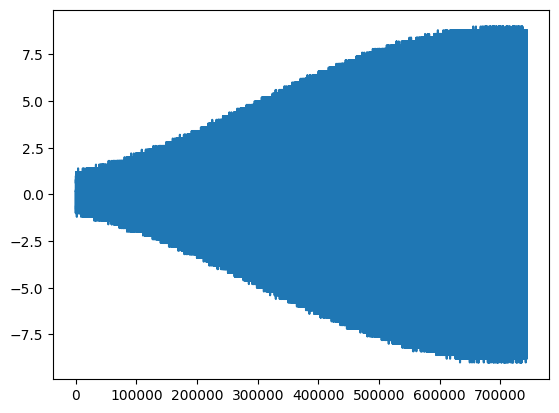

In [23]:
for f in os.listdir('9.1'):
    if f.endswith('.csv'):
        print(f)
        create_logistic_map(os.path.join('9.1', f))

,t,vd,vt
0,-0.009949,-2.3,-0.200000
1,-0.009949,-2.5,0.200000
2,-0.009949,-2.5,0.200000
3,-0.009949,-2.9,0.400000
4,-0.009949,-2.9,0.600000
...,...,...,...
653,-0.009884,-2.9,8.400001
654,-0.009884,-2.9,8.400001
655,-0.009884,-2.5,8.600000
656,-0.009883,-2.5,8.600000


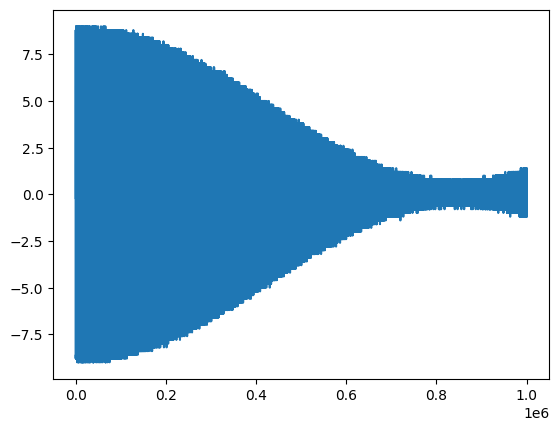

In [13]:
df = load_csv('9.1/34.csv')
plt.plot(df['vt'])
find_range(df, display=False)

first_vd_peak 753
phase_shift 126
nearest_vt_peak 627


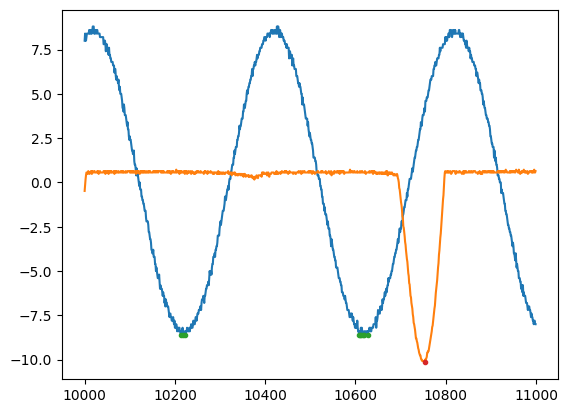

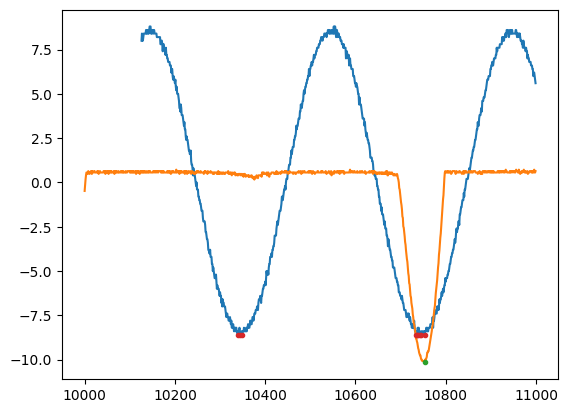

In [18]:

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

start = 10000
df = load_csv('9.1/25.00.csv')
df = df[start:11000]
plt.plot(df['vt'])
plt.plot(df['vd'])
vd_peaks = signal.find_peaks(-1*df['vd'], height=0, width = 100, rel_height=1, prominence=1)
vt_peaks = signal.find_peaks(-1*df['vt'], height=0, width = 100, rel_height=1, prominence=1)
plt.plot(start+vt_peaks[0], -1*vt_peaks[1]['peak_heights'], '.')
plt.plot(10000+vd_peaks[0], -1*vd_peaks[1]['peak_heights'], '.')

first_vd_peak = vd_peaks[0][0]
nearest_vt_peak = find_nearest(vt_peaks[0], first_vd_peak)
phase_shift = first_vd_peak - nearest_vt_peak

print('first_vd_peak', first_vd_peak)
print('phase_shift', phase_shift)
print('nearest_vt_peak', nearest_vt_peak)
df['vt'] = df['vt'].shift(phase_shift)
f = plt.figure()

plt.plot(df['vt'])
plt.plot(df['vd'])
vt_peaks = signal.find_peaks(-1*df['vd'], height=0, width = 100, rel_height=1, prominence=1)
vd_peaks = signal.find_peaks(-1*df['vt'], height=0, width = 100, rel_height=1, prominence=1)
plt.plot(start + vt_peaks[0], -1*vt_peaks[1]['peak_heights'], '.')
plt.plot(start + vd_peaks[0], -1*vd_peaks[1]['peak_heights'], '.')




In [24]:
df[2:]

,t,vd,vt
10000,-0.018000,-0.48,NaN
10001,-0.018000,-0.16,NaN
10002,-0.018000,0.16,NaN
10003,-0.018000,0.40,NaN
10004,-0.018000,0.56,NaN
...,...,...,...
10995,-0.017901,0.64,6.2
10996,-0.017900,0.72,6.2
10997,-0.017900,0.56,6.0
10998,-0.017900,0.56,5.8


In [ ]:
L = 102e-3 # henrry
C = 56.6e-9# farad
resonance = 1 / np.sqrt(L * C) # 13kHz
zmeasurment_freq = 27.1e3 # 27.1kHz

## debug

In [ ]:
# def filter_data(x, y):
#     d = np.abs(np.roll(y, -1) - y)
#     indexes =  np.logical_not(np.logical_and(d > 0.05, d < 0.7))
#     return x[indexes], y[indexes]

df = load_csv('37.4.csv')
df['vt'] = df['vt'].shift(79)
df = df[:600000]
n = int(0)
sdf = df[0:n+20000]
# sdf = df
sdf.reset_index(drop=True, inplace=True)
plt.plot(sdf['vd'])
df['n'] = df.index
# px.scatter(sdf, x='t', y='vd')
peaks = signal.find_peaks(-1*sdf['vd'], height=0, width = 100, rel_height=1, prominence=1)
plt.plot(peaks[0], -1*peaks[1]['peak_heights'], '.')
# plt.plot(peaks[0], peaks[1]['prominences'], '.')
# plt.plot(sdf['vt'])
# p = -1*peaks[1]['peak_heights']
# d = np.abs(np.roll(p, -1) - p)
# indexes =  np.logical_not(np.logical_and(d > 0.05, d < 0.7))
# indexes =  (np.logical_and(d > 0.05, d < 0.7))
# plt.plot(peaks[0][indexes], -peaks[1]['peak_heights'][indexes], '.')
# plt.plot(peaks[0][indexes], d[indexes], '.')

In [ ]:
df = load_csv('37.4.csv')
plt.plot(df['vt'])
np.max()

In [ ]:
df = load_csv('37.4.csv')
df = df[:600000]
vmin = 1.6
vmax = 9
def f(n):    
    return (vmax-vmin)/600000 * n+ vmin

df['vt'] = df['vt'].shift(79)
df['v'] = df.index.map(f)
# df = df[:10000]
peaks = signal.find_peaks(-1*df['vd'], height=0,width = 10, rel_height=1)
indexces, p = filter_data(peaks[0], -1*peaks[1]['peak_heights'])
# indexces = peaks[0]
print(indexces)
pdf = df.iloc[indexces]
# plt.plot()
plt.plot(pdf['vt'], pdf['vd'], '.') 
# plt.plot(len(pdf['vd']) * [-1], pdf['vd'], '.')
# plt.plot(peaks[0], peaks[1]['peak_heights'], '.')


In [ ]:
f = open('a.txt', 'w')
# f = sys.stdout

def groups_average():
    voltages = []
    means = []
    for transmited_voltage in pdf['vt'].unique():
        print(transmited_voltage, file=f)
        vals = pdf[pdf['vt'] == transmited_voltage]['vd'].to_numpy()
        vals = np.sort(vals)
        # print(vals, file=f)

        #
        d = np.abs(np.roll(vals, -1) - vals)
        d[-1] = 0

        filter_ = d > 0.3
        indexes = np.arange(len(filter_))[filter_] + 1
        groups = np.split(vals, indexes)

        for g in groups:
            if np.abs(np.max(g) - np.mean(g)) > 0.5:
                print('vals', vals, file=f)
                print('indexes', indexes, file=f)
                print('g', g, file=f)

            means.append(-np.mean(g))
            voltages.append(-transmited_voltage)
    return voltages, means

plt.plot(voltages, means, '.')
plt.figure()
plt.plot(pdf['vt'], pdf['vd'], '.') 

    

In [ ]:
f = open('a.txt', 'w')
type(f)

In [ ]:
indexces.size, peaks[0].size

In [ ]:
peaks[1]

peaks['prominences']

In [ ]:
pdf['vd'].unique()

In [ ]:
df = load_csv('37.4.csv')
df['vt'] = df['vt'].shift(105)
peaks = signal.find_peaks(-1*df['vd'], height=0,width = 10, rel_height=1)
pdf = df.iloc[peaks[0]]
plt.plot(pdf['v'], pdf['vd'], '.') 

In [ ]:
peaks = signal.find_peaks(sdf['vd'], height=0.5, distance=1000)
peaks

In [ ]:
trace1 = go.Bar(
    x=sdf['t'],
    y=sdf['vd'],
    # name='points',
    # marker=dict(
    #     color='rgb(255,163,192)'
    #            )
)
trace2 = go.Scatter(
    x=peaks[0],
    y=peaks[1]['peak_heights'],
    name='peaks',
    # yaxis='y2',

)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
# fig.add_trace(trace2,secondary_y=True)
fig['layout'].update(height = 600, width = 800,xaxis=dict(
      tickangle=-90
    ))
iplot(fig)


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

trace1 = go.Bar(
    x=df[cat],
    y=df[num],
    name=num,
    marker=dict(
        color='rgb(34,163,192)'
               )
)
trace2 = go.Scatter(
    x=df[cat],
    y=df['cumulative_perc'],
    name='Cumulative Percentage',
    yaxis='y2'

)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig['layout'].update(height = 600, width = 800, title = title,xaxis=dict(
      tickangle=-90
    ))
iplot(fig)


In [ ]:
peaks[0]
peaks[1]['peak_heights']

In [ ]:
import altair as alt
from altair.expr import datum

base = alt.Chart(sdf).encode(
    x='t',
    y='vd',
    color='symbol:N'
).transform_filter(
    datum.symbol == 'GOOG'
)

base.mark_line() + base.mark_point()


In [ ]:
plt.plot(df['vd'])

In [ ]:
df = load_csv('37.4.csv')
df = df[:600000]
vmin = df[:100]['vt'].max()
vmax = df[-100:]['vt'].max()
vmin
vmax
def f(n):    
    return (vmax-vmin)/600000 * n+ vmin
plt.plot(df['vt'])
plt.plot(range(600000), [f(n) for n in range(600000)])
# print(vmin, vmax)
